In [1]:
import os
import yaml
import sys
sys.path.append("..")
import json
import numpy as np
from scipy import ndimage
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from skimage.morphology import skeletonize_3d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import text, patheffects
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from monai.data import DataLoader
import torch
from torch import nn
import networkx as nx
from dataset_road_network import Sat2GraphDataLoader
from dataset_road_network import build_road_network_data
from evaluator import build_evaluator
from trainer import build_trainer
from models import build_model
from utils import image_graph_collate_road_network
from models.matcher import build_matcher
from inference import relation_infer
from losses import SetCriterion
from torch.utils.tensorboard import SummaryWriter

# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

In [3]:
config_file = "/nas/tsgil/relationformer/configs/road_spacenet_gil.yaml"
# config_file = "/nas/tsgil/relationformer/configs/road_test-single_gil.yaml"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config = dict2obj(config)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [1]:
# 시각화 함수 2
def plot_test_sample(image, points, edges):

    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(figsize=(12,5), dpi=150)
    gridspec.GridSpec(1,5)
    ax = plt.subplot2grid((1,4), (0,0), colspan=2, rowspan=1)

    # Displaying the image
    ax.imshow(image*std+mean)
    ax.axis('off')
    
    ax = plt.subplot2grid((1,4), (0,2), colspan=2, rowspan=1)
    
    border_nodes = np.array([[0,0],[0,H],[W,H],[W,0]])
    border_edges = [(0,1),(1,2),(2,3),(3,0)]
    
    G1 = nx.Graph()
    G1.add_nodes_from(list(range(len(border_nodes))))
    coord_dict = {}
    tmp = [coord_dict.update({i:(pts[1],pts[0])}) for i, pts in enumerate(border_nodes)]
    for n, p in coord_dict.items():
        G1.nodes[n]['pos'] = p
    G1.add_edges_from(border_edges)
    
    pos = nx.get_node_attributes(G1,'pos')
    #pos = nx.rescale_layout_dict(pos)
    #pos = nx.circular_layout(G)
    nx.draw(G1, pos, ax=ax, node_size=1, node_color='darkgrey', edge_color='darkgrey', width=1.5, font_size=12, with_labels=False)

    
    G = nx.Graph()
    edges = [tuple(rel) for rel in edges]
    nodes = list(np.unique(np.array(edges)))
    coord_dict = {}
    tmp = [coord_dict.update({i:(W*pts[1],H- H*pts[0])}) for i, pts in enumerate(points)]
    G.add_nodes_from(list(range(len(points))))
    for n, p in coord_dict.items():
        G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    #pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, node_size=10, node_color='lightcoral', edge_color='mediumorchid', width=1.5, font_size=12, with_labels=False)
    # nx.draw_networkx_edge_labels(G, pos, ax=ax, font_size=12, label_pos=0.5, rotate=False)
    
    plt.show()
    
# 시각화 함수 1
def plot_val_rel_sample(image, seg, points1, edges1, points2, edges2, attn_map=None, relative_coords=True):
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(1,4, figsize=(20,5), dpi=150)

    # Displaying the image, 인풋 이미지
    ax[0].imshow(image*std+mean)
    ax[0].axis('off')
    
    # 인풋 seg
    ax[1].imshow(seg)
    ax[1].axis('off')
    
    border_nodes = np.array([[1,1],[1,H-1],[W-1,H-1],[W-1,1]])
    border_edges = [(0,1),(1,2),(2,3),(3,0)]
    
    # 
    G1 = nx.Graph()
    G1.add_nodes_from(list(range(len(border_nodes))))
    coord_dict = {}
    tmp = [coord_dict.update({i:(pts[1],pts[0])}) for i, pts in enumerate(border_nodes)]
    for n, p in coord_dict.items():
        G1.nodes[n]['pos'] = p
    G1.add_edges_from(border_edges)
    
    pos = nx.get_node_attributes(G1,'pos')
    #pos = nx.rescale_layout_dict(pos)
    #pos = nx.circular_layout(G)
    nx.draw(G1, pos, ax=ax[2], node_size=1, node_color='darkgrey', edge_color='darkgrey', width=1.5, font_size=12, with_labels=False)
    # nx.draw_networkx_edge_labels(G, pos, ax=ax, font_size=12, label_pos=0.5, rotate=False)
    nx.draw(G1, pos, ax=ax[3], node_size=1, node_color='darkgrey', edge_color='darkgrey', width=1.5, font_size=12, with_labels=False)

    G = nx.Graph()
    edges = [tuple(rel) for rel in edges1]
    nodes = list(np.unique(np.array(edges)))
    coord_dict = {}
    tmp = [coord_dict.update({nodes[i]:(W*pts[1], H- H*pts[0])}) for i, pts in enumerate(points1[nodes,:])]
    G.add_nodes_from(nodes)
    for n, p in coord_dict.items():
        G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    
    pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    #pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[2], node_size=10, node_color='lightcoral', edge_color='mediumorchid', width=1.5, font_size=12, with_labels=False)
    # nx.draw_networkx_edge_labels(G, pos, ax=ax, font_size=12, label_pos=0.5, rotate=False)
    
    G = nx.Graph()
    edges = [tuple(rel) for rel in edges2]
    nodes = list(np.unique(np.array(edges)))
    coord_dict = {}
    tmp = [coord_dict.update({nodes[i]:(W*pts[1],H- H*pts[0])}) for i, pts in enumerate(points2[nodes,:])]
    G.add_nodes_from(nodes)
    for n, p in coord_dict.items():
        G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    #pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[3], node_size=10, node_color='lightcoral', edge_color='mediumorchid', width=1.5, font_size=12, with_labels=False)
    # nx.draw_networkx_edge_labels(G, pos, ax=ax, font_size=12, label_pos=0.5, rotate=False)
    
    plt.show()

## Debug Dataloader

In [5]:
def image_graph_collate_road_network(batch):
    images = torch.stack([item[0] for item in batch], 0).contiguous()
    seg = torch.stack([item[1] for item in batch], 0).contiguous()
    points = [item[2] for item in batch]
    edges = [item[3] for item in batch]
    return [images, seg, points, edges]

In [6]:
val_ds, file_infos = build_road_network_data( # 이 함수는 폴더에서 셔플해서 ds 생성함
    config, mode='test', loadXYN=True
)
# print(len(val_ds))
# print(val_ds[0])

val_loader = DataLoader(val_ds,
                        batch_size=config.DATA.BATCH_SIZE,
                        shuffle=False,
                        num_workers=config.DATA.NUM_WORKERS,
                        collate_fn=image_graph_collate_road_network,
                        pin_memory=True)
len(val_loader) # 이터레이션 수

14

## Debug Trained Model

In [7]:
model = build_model(config)
device = torch.device("cuda")
model = model.to(device)

In [8]:
ckpt_path = '/nas/tsgil/relationformer/trained_weights/runs/baseline_road_resnet_def_detr_final_dec_4_10/models/checkpoint_epoch=100.pt' # 경로 수정하여 사용
checkpoint = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint['net'], strict=False)
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))

In [9]:
from PIL import Image
import json

model.eval() # 인퍼런스 모드
gil_path = f'/nas/tsgil/relationformer/gil/spacenet_test_data_region'
# gil_path = f'/nas/tsgil/relationformer/gil/test_single_data_region' # test-single
if not os.path.isdir(gil_path):
    os.makedirs(gil_path)
    os.makedirs(gil_path + "/patch")
    os.makedirs(gil_path + "/seg")
    os.makedirs(gil_path + "/graph")
else:
    if not os.path.isdir(gil_path + "/patch"):
        os.makedirs(gil_path + "/patch")
    if not os.path.isdir(gil_path + "/seg"):
        os.makedirs(gil_path + "/seg")
    if not os.path.isdir(gil_path + "/graph"):
        os.makedirs(gil_path + "/graph")
    print("The path is already ready.")
iteration = 0
for idx, (images, seg, points, edges) in enumerate(val_loader): # 이터레이션 만큼 패치 배치에 대한 파일 생성
    iteration = iteration+1
    images = images.cuda()
    # print(images.shape) # [32, 3, 128, 128]
    seg = seg.cuda()
    h, out, _ = model(images, seg=False)
    pred_nodes, pred_edges, pred_nodes_box, pred_nodes_box_score, pred_nodes_box_class, pred_edges_box_score, pred_edges_box_class = relation_infer(
                h.detach(), out, model, config.MODEL.DECODER.OBJ_TOKEN, config.MODEL.DECODER.RLN_TOKEN,
                nms=False, map_=True
                )
    # plot_val_rel_sample(images[0].permute(1,2,0).cpu().numpy(), seg[0].permute(1,2,0).cpu().numpy(), points[0].cpu().numpy(), edges[0].cpu().numpy(), pred_nodes[0].cpu().numpy(), pred_edges[0])
    # print(images[0].shape) # [3, 128, 128]
    # print(images[0].permute(1,2,0).shape) # [128, 128, 3]
    start_idx = idx*config.DATA.BATCH_SIZE
    for i in range(len(images)): # 0~31
        file_name = file_infos[start_idx+i]
        sample_id, x, y, region_num = file_name.split('_')
        # img of patch
        # NumPy 배열을 PIL 이미지로 변환
        image = images[i].cpu().numpy()
        min_value = np.min(image)
        max_value = np.max(image)
        image = (image - min_value) / (max_value - min_value)
        image = (image * 255).astype('uint8')
        image = image.transpose(1,2,0)
        image = Image.fromarray(image, 'RGB')
        # 이미지 파일로 저장할 경로 지정
        save_path = f'{gil_path}/patch/{file_name}.png'
        # 이미지 파일로 저장
        image.save(save_path)
        # seg
        image = seg[i].cpu().numpy()
        image = image+0.5
        image = (image * 255).astype('uint8')
        image = np.squeeze(image, axis=0)
        image = Image.fromarray(image, 'L')
        save_path = f'{gil_path}/seg/{file_name}.png'
        image.save(save_path)
        # gt node edge
        gt_node, gt_edge = points[i].cpu().numpy(), edges[i].cpu().numpy()
        # pred node edge
        pred_node, pred_edge = pred_nodes[i].cpu().numpy(), pred_edges[i]
        gt_node_list = gt_node.tolist()
        gt_edge_list = gt_edge.tolist()
        pred_node_list = pred_node.tolist()
        pred_edge_list = pred_edge.tolist()
        data = {
            "gt_node": gt_node_list,
            "gt_edge": gt_edge_list,
            "pred_node": pred_node_list,
            "pred_edge": pred_edge_list
        }
        # JSON 파일로 저장
        with open(f'{gil_path}/graph/{file_name}.json', 'w') as json_file:
            json.dump(data, json_file, indent=2)
    # 정답 사진, 정답 Seg, 정답 노드와 엣지, 예측 노드와 엣지
    print('Iteration:',iteration)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mod

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14


2023-11-23 10:06:12,625 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


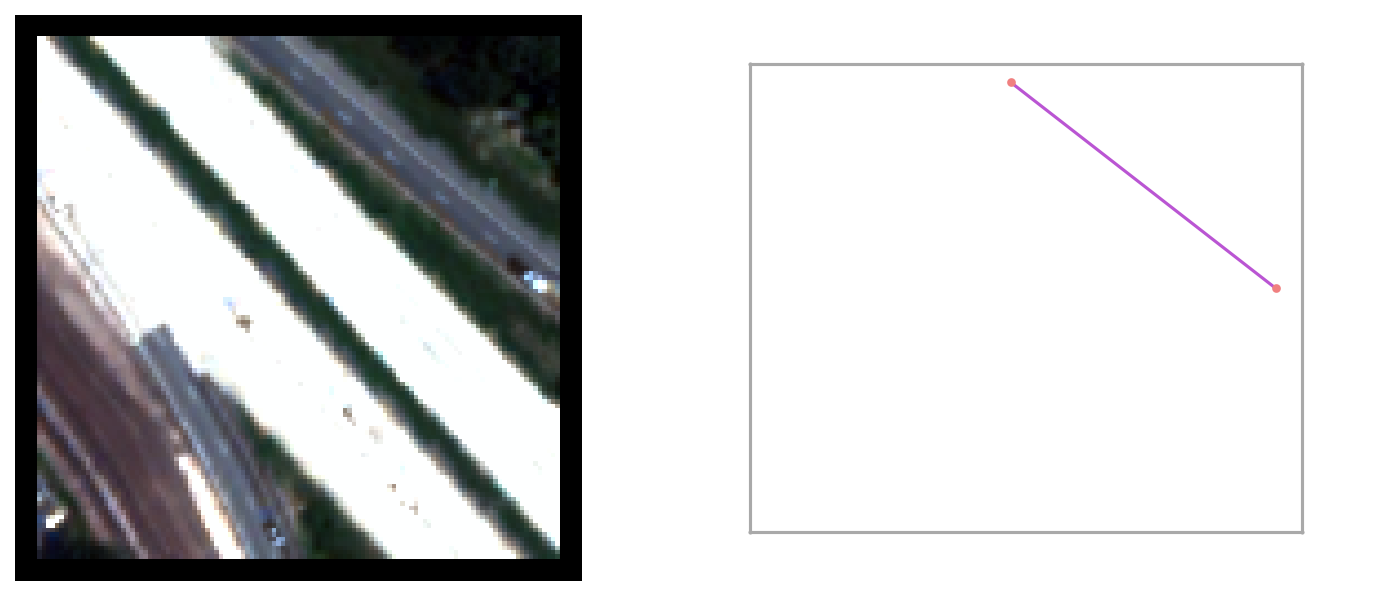

In [10]:
plot_test_sample(images[0].permute(1,2,0).cpu().numpy(), pred_nodes[0].cpu().numpy(), pred_edges[0]) # 0~31
# 정답 사진, 예측 노드와 엣지

In [11]:
# def match_name_keywords(n, name_keywords):
#     out = False
#     for b in name_keywords:
#         if b in n:
#             out = True
#             break
#     return out

In [12]:
# param_dicts = [
#     {
#         "params":
#             [p for n, p in model.named_parameters()
#              if not match_name_keywords(n, ['enoder','reference_points', 'sampling_offsets']) and p.requires_grad],
#         "lr": float(config.TRAIN.LR)
#     },
#     {
#         "params": [p for n, p in model.named_parameters() if match_name_keywords(n, ["enoder"]) and p.requires_grad],
#         "lr": float(config.TRAIN.LR_BACKBONE)
#     },
#     {
#         "params": [p for n, p in model.named_parameters() if match_name_keywords(n, ['reference_points', 'sampling_offsets']) and p.requires_grad],
#         "lr": float(config.TRAIN.LR) * 0.1
#     }
# ]